<a href="https://colab.research.google.com/github/arunavaangshuman/PDE/blob/main/initBSE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade pip
!pip install cirq
!pip install -q qsimcirq --quiet
!python -m pip install scikit-quant

In [ ]:
# auther- Arunava

In [ ]:
import numpy as np
import cirq
import skquant.opt as skqopt #optimization routines
from matplotlib import pyplot as plt #plotting tool

In [ ]:
import time

In [ ]:
# creating SU(4) to compare with SO(4) and SU(4) includes imaginary terms also
class SU4(cirq.Gate):

    def __init__(self, thetas, inverse=False):
        if (len(thetas)!=15):
            raise ValueError("thetas must be a list of 15 variational parameters")
        self.thetas=thetas
        self.inverse=inverse

    def _num_qubits_(self):
        #We are required to implement this method, 
        #it specifies the number of qubits our gate acts on
        return 2

    def _decompose_(self, q):
        #AltSO(4) gate object takes two qubits as input
        if (not self.inverse):
          # circuit for A1
            yield cirq.rz(self.thetas[0]).on(q[0])
            yield cirq.ry(self.thetas[1]).on(q[0])
            yield cirq.rz(self.thetas[2]).on(q[0])
            yield cirq.rz(self.thetas[3]).on(q[1])
            yield cirq.ry(self.thetas[4]).on(q[1])
            yield cirq.rz(self.thetas[5]).on(q[1])
            yield cirq.CNOT(q[1], q[0])
            yield cirq.rz(self.thetas[6]).on(q[0])
            yield cirq.ry(self.thetas[7]).on(q[1])
            yield cirq.CNOT(q[0], q[1])
            yield cirq.ry(self.thetas[8]).on(q[1]) 
            yield cirq.CNOT(q[1], q[0]) 
            yield cirq.rz(self.thetas[9]).on(q[0])
            yield cirq.ry(self.thetas[10]).on(q[0])
            yield cirq.rz(self.thetas[11]).on(q[0])
            yield cirq.rz(self.thetas[12]).on(q[1])
            yield cirq.ry(self.thetas[13]).on(q[1])
            yield cirq.rz(self.thetas[14]).on(q[1])
            
        else:
            yield cirq.rz(-self.thetas[14]).on(q[1])
            yield cirq.ry(-self.thetas[13]).on(q[1])
            yield cirq.rz(-self.thetas[12]).on(q[1])
            yield cirq.rz(-self.thetas[11]).on(q[0])
            yield cirq.ry(-self.thetas[10]).on(q[0])
            yield cirq.rz(-self.thetas[9]).on(q[0])
            yield cirq.CNOT(q[1], q[0])
            yield cirq.rz(-self.thetas[8]).on(q[1])
            yield cirq.ry(-self.thetas[7]).on(q[1])
            yield cirq.CNOT(q[0], q[1])
            yield cirq.ry(-self.thetas[6]).on(q[0]) 
            yield cirq.CNOT(q[1], q[0]) 
            yield cirq.rz(-self.thetas[5]).on(q[1])
            yield cirq.ry(-self.thetas[4]).on(q[1])
            yield cirq.rz(-self.thetas[3]).on(q[1])
            yield cirq.rz(-self.thetas[2]).on(q[0])
            yield cirq.ry(-self.thetas[1]).on(q[0])
            yield cirq.rz(-self.thetas[0]).on(q[0])
             
    def _unitary_(self):
        #Some other method we need in order to get inverses of U to work
        #as we will need them in our circuits
        return cirq.unitary(cirq.Circuit(self._decompose_(cirq.LineQubit.range(2))))
    


In [ ]:
class U(cirq.Gate):
    def __init__(self, n, d, l, inverse=False):
        #n := number of qubits
        #d := depth (number of layers)
        #l := list of variational parameters. Must be 6*(n-1)*d parameters
        #we specify the variational parameter when we declare a U gate object
        if (len(l)!=(15*(8-1)*d)):
            raise ValueError("Incorrect number of parameters. l must be of length 6*(n-1)*d")
        self.n=n
        self.d=d
        self.l=l
        self.inverse=inverse
    
    def _decompose_(self, q):
        #U gate object takes in n qubits as input
        if (not self.inverse):
            for i in range(self.d):
                for j in range(0, self.n-1, 2):
                    yield SU4(self.l[15*(self.n-1)*i+15*j:15*(self.n-1)*i+15*j+15]).on(q[j], q[j+1])
                for j in range(1, self.n-1, 2):
                    yield SU4(self.l[15*(self.n-1)*i+15*j:15*(self.n-1)*i+15*j+15]).on(q[j], q[j+1])
        else:
            for i in range(self.d-1, -1, -1):
                if (n%2==1):
                    for j in range(self.n-2, -1, -2):
                        yield SU4(self.l[15*(self.n-1)*i+15*j:15*(self.n-1)*i+15*j+15], True).on(q[j], q[j+1])
                    for j in range(self.n-3, -1, -2):
                        yield SU4(self.l[15*(self.n-1)*i+15*j:15*(self.n-1)*i+15*j+15], True).on(q[j], q[j+1])
                else:
                    for j in range(self.n-3, -1, -2):
                        yield SU4(self.l[15*(self.n-1)*i+15*j:15*(self.n-1)*i+15*j+15], True).on(q[j], q[j+1])
                    for j in range(self.n-2, -1, -2):
                        yield SU4(self.l[15*(self.n-1)*i+15*j:15*(self.n-1)*i+15*j+15], True).on(q[j], q[j+1])
                    
        
    def _num_qubits_(self):
        #We are required to implement this method, 
        #it specifies the number of qubits our gate acts on
        return self.n   
    
    def _unitary_(self):
        #Some other method we need in order to get inverses of U to work
        #as we will need them in our circuits
        return cirq.unitary(cirq.Circuit(self._decompose_(cirq.LineQubit.range(self.n))))

In [ ]:
def checkwave(l,d,n):
    #create circuit object for adding gates to
    circuit = cirq.Circuit()
    #specify number of qubits we want in our circuit
    q = [cirq.GridQubit(0, i) for i in range(n)]
    
    #Add our custom gate class U to our circuit and make sure it acts
    #on all qubits *q
    
    circuit.append(U(n=8,d=2,l=l[1:d*15*(8-1)+1]).on(*q[2:]))
    
    param=d*15*(8-1)+1
    #for i in range(4,n):
    #    circuit.append(cirq.rz(l[param]).on(q[i]))
    #    param+=1
    count=0
   # for i in range(4,10):
   #     circuit.append(SU2(l[param:param+i-(1+count)])).on(q[i])
   #     param+=param+3  
   #     count=count+1  

    for i in range(2,10):
      for j in range(1):
        circuit.append(cirq.rz(l[param+j]).on(q[i]))
        circuit.append(cirq.ry(l[param+j+1]).on(q[i]))
        circuit.append(cirq.rz(l[param+j+2]).on(q[i]))
      param+=3 
    circuit.append(cirq.qft(*q))
    

    #Create simulator object
    simulator = cirq.Simulator()
    
    #Direct wavefunction access
    result = simulator.simulate(circuit).state_vector()
    
    #create final state 
    func = l[0]*np.real(result)
    return func

In [ ]:
def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

def element_butterfly(S, loss, profit, strike, sstrike):
    if (strike>=sstrike or profit<=loss):
        raise ValueError("Impossible args")
        
    def outer(S):
        return loss

    def pos(S):
        return loss+(profit-loss)*(S-strike)/(sstrike-strike)
    
    def neg(S):
        return profit - (profit-loss)*(S-sstrike)/(sstrike-strike)
    
    if (S <= strike or S>(2*sstrike-strike)):
        return outer(S)
    
    if ((S>strike) and (S<=sstrike)):
        return pos(S)
    
    if ((S>sstrike) and (S<=(2*sstrike-strike))):
        return neg(S)


'''
Function to generate f(S) where f is the butterfly call option, and S is
a numpy array corresponding to the value of the stock at each point.
loss= minimum option price (usually  negative)
profit= peak option price
strike= strike price (stock price when option's value starts to grow')
sstrike= sell strike price (stock price when option's value reaches peak (profit)')
returns: numpy array
'''
def butterfly(S, loss, profit, strike, sstrike):
    return np.vectorize(element_butterfly, otypes="f")(S, loss, profit, strike, sstrike)

'''
Function to generate f(x), where f is the butterfly call option, and x is
the natural log of stock price S
returns: numpy array
'''
def trans_butterfly(x, loss, profit, strike, sstrike):
    return butterfly(np.exp(x), loss, profit, strike, sstrike)


In [ ]:
def initializer(n=8, d=1, func='butterfly'):
    if (func=='sin'):
        x=np.linspace(0,1,2**n)
        f=np.sin(2*np.pi*x)
        xlim=(0, 1)
        ylim=(-1, 1)
    elif (func=='gauss'):
        x=np.linspace(0,1,2**n)
        f=gaussian(x, 0.5, 0.2)
        xlim=(0, 1)
        ylim=(0, 1)
    elif (func=='butterfly'):
        x=np.linspace(0, 2.3, 2**n)
        f=trans_butterfly(x, -5, 10, 2, 5)
        xlim=(0, 2.3)
        ylim=(-5, 10)
    
    

In [ ]:
d=2
n=10

In [ ]:
x0=np.concatenate(([10*np.random.random()],2*np.pi*np.random.rand(d*15*(8-1)+24)))
checkwave(x0,d,n)

array([ 0.1312868 ,  0.03433986,  0.03969111, ..., -0.2188418 ,
       -0.1850454 ,  0.04568925], dtype=float32)

In [ ]:
def c(l):
    x=np.linspace(0, 2.3, 2**n)
    # f is changeble if want to take gaussian then we can replace trans_butter... by gaussian or sin if sin is needed
    # simply take functions 
    f=trans_butterfly(x, -5, 10, 2, 5)
    return np.linalg.norm(checkwave(l,d,n)-f)**2

In [ ]:
def c1(l):
    x=np.linspace(0,1,2**n)
    # f is changeble if want to take gaussian then we can replace trans_butter... by gaussian or sin if sin is needed
    # simply take functions 
    f=np.sin(2*np.pi*x)
    return np.linalg.norm(checkwave(l,d,n)-f)**2

In [ ]:
def c2(l):
    x=np.linspace(0,1,2**n)
        
    # f is changeble if want to take gaussian then we can replace trans_butter... by gaussian or sin if sin is needed
    # simply take functions 
    f=gaussian(x, 0.5, 0.2)
    return np.linalg.norm(checkwave(l,d,n)-f)**2

In [ ]:
bounds = [[0,240]] #first bound is lambda0, best choice of bounds usually
#depends on number of qubits we are using

#the rest of the bounds are the angle theta in Ry(theta)
for i in range(d*15*(8-1)+24):
    bounds.append([0,2*np.pi])

In [ ]:
    budget = 100000

In [ ]:
x0=np.concatenate(([240*np.random.random()],2*np.pi*np.random.rand(d*15*(8-1)+24)))

#Optimize using Imfil
result, history = skqopt.minimize(c, x0, bounds, budget, method='imfil')

In [ ]:
x0=np.concatenate(([240*np.random.random()],2*np.pi*np.random.rand(d*15*(8-1)+24)))
result1, history1 = skqopt.minimize(c1, x0, bounds, budget, method='imfil')

In [ ]:
bounds2 = [[0,30]] #first bound is lambda0, best choice of bounds usually
#depends on number of qubits we are using

#the rest of the bounds are the angle theta in Ry(theta)
for i in range(d*15*(8-1)+24):
    bounds2.append([0,2*np.pi])

In [ ]:
x0=np.concatenate(([30*np.random.random()],2*np.pi*np.random.rand(d*15*(8-1)+24)))
result2, history2 = skqopt.minimize(c2, x0, bounds2, budget, method='imfil')

In [ ]:
linit=result.optpar

In [ ]:
linit1=result1.optpar

In [ ]:
linit2=result2.optpar

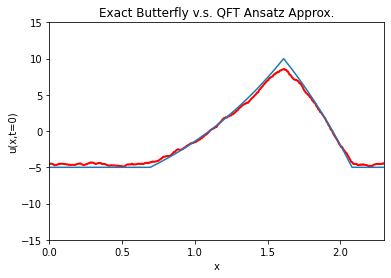

In [ ]:
#init_bound=[[0,200]]
fig = plt.figure()
y=np.linspace(0, 2.3, 2**n)
ax = plt.axes(xlim=(0, 2.3),ylim=(-15, 15))
line, = ax.plot(y, checkwave(linit,d,n), 'r', lw=2)
line2, = ax.plot(y,trans_butterfly(y, -5, 10, 2, 5))
plt.xlabel('x')
plt.ylabel('u(x,t=0)')
plt.title('Exact Butterfly v.s. QFT Ansatz Approx.')
plt.savefig('qftplot.png')

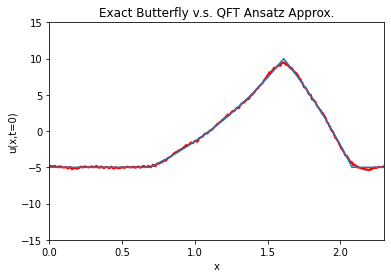

In [ ]:
#init_bound=[[0,240]]
fig = plt.figure()
y=np.linspace(0, 2.3, 2**n)
ax = plt.axes(xlim=(0, 2.3),ylim=(-15, 15))
line, = ax.plot(y, checkwave(linit,d,n), 'r', lw=2)
line2, = ax.plot(y,trans_butterfly(y, -5, 10, 2, 5))
plt.xlabel('x')
plt.ylabel('u(x,t=0)')
plt.title('Exact Butterfly v.s. QFT Ansatz Approx.')
plt.savefig('qftplot.png')

In [ ]:
linit[0]

219.36349220822373

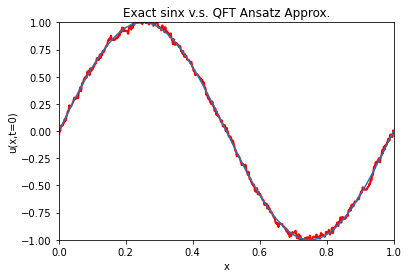

In [ ]:
fig = plt.figure()
y=np.linspace(0, 1, 2**n)
ax = plt.axes(xlim=(0, 1),ylim=(-1, 1))
line, = ax.plot(y, checkwave(linit1,d,n), 'r', lw=2)
line2, = ax.plot(y,np.sin(2*np.pi*y))
plt.xlabel('x')
plt.ylabel('u(x,t=0)')
plt.title('Exact sinx v.s. QFT Ansatz Approx.')
plt.savefig('qftplot.png')

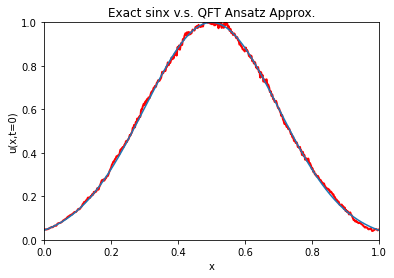

In [ ]:
fig = plt.figure()
y=np.linspace(0, 1, 2**n)
ax = plt.axes(xlim=(0, 1), ylim=(0, 1))
line, = ax.plot(y, checkwave(linit2,d,n), 'r', lw=2)
line2, = ax.plot(y,gaussian(y, 0.5, 0.2))
plt.xlabel('x')
plt.ylabel('u(x,t=0)')
plt.title('Exact sinx v.s. QFT Ansatz Approx.')
plt.savefig('qftplot.png')